In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../qdmt/')

In [3]:
from uMPSHelpers import *
from hamiltonian import TransverseIsing
from vumps import vumps 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, eig
from tqdm import tqdm
import cirq

### Loading the params

In [5]:
dataFile = 'data/081123102003_opt_log.csv'
data = np.loadtxt(dataFile, delimiter=',', skiprows=1)
with open(dataFile, 'r') as dataF:
    header = dataF.readline()

In [6]:
header = header.split(',')
print(len(header))
print(header)

18
['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7', 'θ8', 'θ9', 'θ10', 'θ11', 'θ12', 'θ13', 'θ14', 'fun', 'nfev', 'nit\n']


In [7]:
params = data[:, :-3]

### Converting params into state tensors

In [8]:
class ShallowFullStateAnsatz(cirq.Gate):
    def __init__(self, Psi):
        assert len(Psi) == 15
        self.Psi = Psi

    def _decompose_(self, qubits):
        return [
            cirq.rz(self.Psi[0]).on(qubits[0]),
            cirq.rx(self.Psi[1]).on(qubits[0]),
            cirq.rz(self.Psi[2]).on(qubits[0]),

            cirq.rz(self.Psi[3]).on(qubits[1]),
            cirq.rx(self.Psi[4]).on(qubits[1]),
            cirq.rz(self.Psi[5]).on(qubits[1]),

            cirq.CNOT(qubits[0], qubits[1]),

            cirq.ry(self.Psi[6]).on(qubits[0]),

            cirq.CNOT(qubits[1], qubits[0]),

            cirq.ry(self.Psi[7]).on(qubits[0]),
            cirq.rz(self.Psi[8]).on(qubits[1]),

            cirq.CNOT(qubits[0], qubits[1]),

            cirq.rz(self.Psi[9]).on(qubits[0]),
            cirq.rx(self.Psi[10]).on(qubits[0]),
            cirq.rz(self.Psi[11]).on(qubits[0]),

            cirq.rz(self.Psi[12]).on(qubits[1]),
            cirq.rx(self.Psi[13]).on(qubits[1]),
            cirq.rz(self.Psi[14]).on(qubits[1]),
        ]

    def num_qubits(self):
        return 2

    def _circuit_diagram_info_(self, args):
        return ['U','U']


In [9]:
def unitary_to_tensor(U):
    '''
    Take a unitary U and make it a tensor A such that
   |0>     k
    |     |
    |     |     |
    ---U---     | direction of unitary
    |     |     |
    |     |     v
    i     j

    A.shape = (i, j, k)

    i == A == k
         |
         j
    '''
    n = int(np.log2(U.shape[0]))
    zero = np.array([1., 0.])

    Ucontr = list(range(-1, -n-1, -1)) + [1] + list(range(-n-1, -2*n, -1))
    A = ncon([U.reshape(*2 * n *[2]), zero], [Ucontr, [1,]])
    A = A.reshape(2**(n-1), 2, 2**(n-1))
    return A


def paramsToTensor(params):
    Q = cirq.LineQubit.range(2)

    U = cirq.unitary(
        ShallowFullStateAnsatz(params).on(*Q)  # 2 qubit circuit
    )
    
    return unitary_to_tensor(U)

In [10]:
Ats = [paramsToTensor(p) for p in params]
Ats = [normalizeMPS(A) for A in Ats]

### Calculating the Loschmidt curve using state TM

In [11]:
def right_fixed_point(E):
    '''
    Calculate the right fixed point of a transfer matrix E

    E.shape = (N, N)
    '''
    evals, evecs = eig(E)
    sort = sorted(zip(evals, evecs), key=lambda x: np.linalg.norm(x[0]),
                   reverse=True)
    # Look into `scipy.sparse.linalg.eigs, may be faster`
    mu, r = sort[0]
    return mu, r


def exact_overlap(A, B):
    '''
    Calculate the overlap classically i.e. abs of max eigenvalue of transfer
    matrix
    '''
    D, d, _ = A.shape
    E = ncon([A, B.conj()], ((-1, 1, -3), (-2, 1, -4))).reshape(D**2, D**2)

    mu, _ = right_fixed_point(E)

    return np.abs(mu)


In [12]:
ls = []
A0 = Ats[0]

for A in Ats: 
    ov = exact_overlap(A0, A)
    ls.append(-1*np.log(ov))

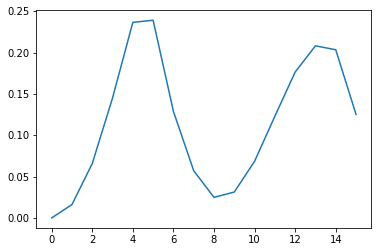

In [13]:
plt.plot(ls)

### Calculating Loschmidt using density matrices

In [14]:
from optimise import uniformToRhoN

In [15]:
from optimise import contractionTrAA

In [16]:
fixPs = [fixedPoints(A) for A in Ats]

In [17]:
def TrAB(A, B, N, fixedA=None, fixedB=None):
    if fixedA is None: 
        fixedA = fixedPoints(A)
    if fixedB is None: 
        fixedB = fixedPoints(B)
    lA, rA = fixedA
    lB, rB = fixedB
        
    BContr, BDagContr, AContr, ADagContr = contractionTrAA(N)
    
    lBContr = [[BDagContr[0][0], BContr[0][0]]]
    rBContr = [[BContr[-1][2], BDagContr[-1][2]]]
    
    lAContr = [[ADagContr[0][0], AContr[0][0]]]
    rAContr = [[AContr[-1][2], ADagContr[-1][2]]]
    
    contr = lBContr + BContr + BDagContr + rBContr +\
            lAContr + AContr + ADagContr + rAContr
    tensors = [lB] + [B]*N + [B.conj()]*N + [rB] +\
            [lA] + [A]*N + [A.conj()]*N + [rA]
    
    return ncon(tensors, contr)

In [18]:
overlapNDict = {}
Ns = [2, 4, 8, 12, 16]
A0 = Ats[0]
f0 = fixPs[0]
for N in Ns: 
    overlapNDict[N] = []
    for fA, A in zip(fixPs, Ats): 
        overlapNDict[N].append(TrAB(A0, A, N, f0, fA))


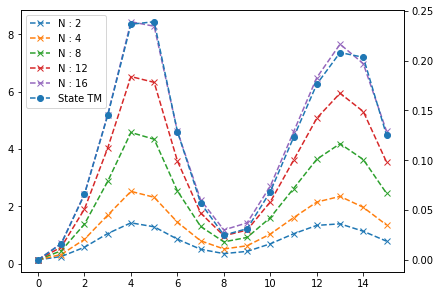

In [20]:
fig, ax = plt.subplots(layout='constrained')
lines = []
for N in Ns:
    ovs = np.abs(overlapNDict[N])
    losch = -1*np.log(ovs)
    line = ax.plot(losch, label=f'N : {N}', ls='--', marker='x')
    lines = lines + line
    
ax2 = ax.twinx()
line = ax2.plot(ls, label='State TM', ls='--', marker='o')
lines = lines + line

labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)

plt.show()